### AB testing TASK

We are a marketing technology company that develops solutions for the digital advertising space (AdTech). This assessment is designed to allow you to showcase your analytical abilities on a simplified version of a problem we usually work on.  You will have an opportunity to walk a couple of the Data Scientists’ through your solution over a video call or possibly in person.

We don't expect this to be a time-intensive exercise for you. At a minimum, we expect you to answer the questions fully and to the best of your ability, with all code and output shown, well formatted, and well documented. You can choose any widely adopted language (Python, R, Julia, ...) and tool (Jupyter notebooks, Rmd, ...) to best showcase your work. However, we do have a preference for Python because it's what we use internally.  Please have any code used to generate solutions or output you think useful in describing your approach ready to present during your presentation.

Problem Description
We have run a digital advertising campaign for one of our clients, targeting mobile users in the Southeast. The goal of the campaign was to drive conversions -- users clicking through the ad and accepting our client's offer. To execute this campaign, we built an audience of target users based on historical information about the likelihood to convert.

Our campaigns are executed on real-time bidding (RTB) exchanges. Web pages or mobile apps submit bid requests to potential advertisers on these exchanges. If we see a bid request for a user we want to target on a web page or mobile app we want to serve on, we will submit a bid for that advertising placement. If we submit the highest (or only) bid, we win the placement and serve an ad. Given that we have won and served the ad, a user then has the opportunity to convert.

We'd like you to take a look at the campaign's results to answer two primary questions:

1.	We ran two creatives (distinct ad designs) during the campaign: a baseline creative in line with our client's previous campaigns, and a new creative designed to increase conversions by more prominently displaying the offer to the user.  To do this, we assigned some users to a "test" group that received the new ad during the campaign.  Did the new creative increase conversions?
2.	We are equally likely to bid on any user at any time during a campaign.  Other advertisers have found success by "retargeting" users -- increasing the likelihood of a bid for users that have previously landed on a page or actually converted in the past (e.g. redeeming a digital coupon). Would retargeting have improved performance for this campaign?

Data: there are two files available for download.  These files are as follows:

user_attributes.csv.gz is a compressed CSV file of target users'; user_id is a unique identifier for each user; attributes is a text blob of the user's attributes; age is the user's age in years; gender is the user's inferred gender; location is the user's state of residence; test is a binary variable indicating that the user belongs to the test group

bid_requests.csv.gz is a compressed CSV file of bid requests that we have seen for the targeted users. Each row represents one (bid) request.
timestamp is the time the bid request was received. This is unique for each request and can be treated as a unique key.; user_id is the unique identifier for user the request is for; bid is a binary variable indicating whether we made a bid for this request; win is a binary variable indicating whether we submitted the winning bid and served an ad; conversion is a binary variable indicating whether the user converted after seeing the ad

Exercises / Questions
1.	What do the different distributions of requests by user tell us?
Please describe the distributions related to requests and the users we targeted.

2.	Based on insights from #1, was the test effective?
Were test users more likely to convert than control users?

3.	Should we consider retargeting users that have previously converted?
Would retargeting users in this campaign have improved performance?



### Results
1.	What do the different distributions of requests by user tell us?
Please describe the distributions related to requests and the users we targeted.

###### the distributions differ between the control and test group for variables and points in the funnel where they should be the ~same

2.	Based on insights from #1, was the test effective?
Were test users more likely to convert than control users?

###### NO the test was not effective but after balancing the sample I could show a significant 0.79 % increase in conversation rate due to the new ad

3.	Should we consider retargeting users that have previously converted?
Would retargeting users in this campaign have improved performance?

###### after balancing the sample I could show a significant >23% higher conversation rate for users that had a prior conversation

### Workflow
1. loading the libraries
2. load the two files and explore rangers and distributions
3. merge the two files and check merge success
4. plot user attributes per bid=1, win=1 and conversion=1
5. do sanity checks on fractions of bids and wins are the same for the control and test group: 
   a) H0 = no significant differences between the control and test group bid successes        
   b) H0 = no significant differences between the control and test group wins/bids ratio
6. compare distributions of the control and test groups  (per bid=1, win=1 and conversion=1)
###### .
7. 'fix' the distribution issue at bid=1 and win=1 funnel levels by taking a subsample w inclusion probability equal to the states' population 
8. plot to verify that distributions at win=1 funnel level are ~equal between control and test groups
9. run an AB test to see if HO = no difference between conversation rates should be rejected
10. calculate the sample size requires to get 95% confidence and 80% power
11. plot the confidence bounds and power of the AB test
###### .
12. build retargeting test groups
13. compare distributions of the retargeting control and test groups (per bid=1, win=1 and conversion=1)
14. 'fix' the distribution issue by taking a subsample w inclusion probability equal to the states' population 
15. plot to verify that distributions ~equal between retargeting control and test groups
16. calculate the sample size requires to get 95% confidence and 80% power
17. run an AB test to see if HO = no difference between conversation rates can be rejected 
18. plot the confidence bounds and power of the AB test

In [ ]:
### import python libs

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as scs
from scipy.stats import norm

import math as mt
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# set plt style
plt.style.use('ggplot') 

In [2]:
# import functions from functions.py
from functions import df_shape_nacount_unique_countlist, plot_time_series, plot_attribute_bars, subsample_state, pooled_prob, pooled_SE, confidence_interval, z_val, ab_dist, min_sample_size, p_val, plot_norm_dist, plot_CI, plot_null, plot_alt, abplot, show_area, get_z_score, get_sds, get_sampSize 

In [ ]:
######################################################################################################################
######################################################################################################################

### read csv files

In [11]:
# read the first datasets provided
df_bid_requests = pd.read_csv('bid_requests.csv')  

In [12]:
# adding a column called date_time where the date and time information is converted to date and time
df_bid_requests["date_time"] = df_bid_requests["timestamp"].astype("datetime64")

In [13]:
# read user_attributes.csv
val_pat_str = r'[A-Z]+'
val_pat_int = r'\d+'
user_id = []
ages = []
genders = []
location = []
test = []

with open('user_attributes.csv') as f:
    for line in f:
        if(line[:7] != 'user_id'): # skip header
            user_id.append(line.split(',', 1)[0])
            ages.append(re.findall(val_pat_int, line.split(',', 1)[1])[0])
            test.append(re.findall(val_pat_int, line.split(',', 1)[1])[1])
            genders.append(re.findall(val_pat_str, line.split(',', 1)[1])[0])
            location.append(re.findall(val_pat_str, line.split(',', 1)[1])[1])

data_dict ={'user_id': user_id, 
            'age': ages, 
            'gender': genders, 
            'location': location,
            'test': test}
df_user_attributes = pd.DataFrame.from_dict(data_dict)

### explore df_bid_requests

In [14]:
df_bid_requests.head()

,timestamp,user_id,bid,win,conversion,date_time
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,2017-01-01 00:00:01
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0,2017-01-01 00:00:02
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0,2017-01-01 00:00:05
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0,2017-01-01 00:00:12
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0,2017-01-01 00:00:13


In [15]:
# look at data frame shape, count NA per column, count and list unique values per column
df_shape_nacount_unique_countlist(df_bid_requests)

shape
(600000, 6)

timestamp
Na count
0

user_id
Na count
0

bid
Na count
0

win
Na count
0

conversion
Na count
0

date_time
Na count
0

timestamp
unique count
600000
unique list
['2017-01-01 00:00:01' '2017-01-01 00:00:02' '2017-01-01 00:00:05' ...
 '2017-01-23 13:19:23' '2017-01-23 13:19:24' '2017-01-23 13:19:28']

user_id
unique count
63137
unique list
['be7485be5b6eb3690efcbc9e95e8f15a' '26c5dca2512a4c7fe8810bd04191b1b3'
 '2121376a323507c01c5e92c39ae8ccd4' ... '9fc64354454711c97058db6110b3a369'
 '6645081859c05aa9e8a19c1404d8e680' 'af7df23d7ea1cd6dacdddd933fe1f447']

bid
unique count
2
unique list
[0 1]

win
unique count
2
unique list
[0 1]

conversion
unique count
2
unique list
[0 1]

date_time
unique count
600000
unique list
['2017-01-01T00:00:01.000000000' '2017-01-01T00:00:02.000000000'
 '2017-01-01T00:00:05.000000000' ... '2017-01-23T13:19:23.000000000'
 '2017-01-23T13:19:24.000000000' '2017-01-23T13:19:28.000000000']



- no Na 
- timestamp unique count = sample count
- number of unique users are ~ 1/10 of number of lines in the file

- bid, win and conversion are binary (as expected)

In [16]:
# look at summary stats for numeric
df_bid_requests.describe(percentiles = [.01, .05, .1, .25, .40, .60, .75, .80, .90, .95, .99])  

,bid,win,conversion
count,600000.000000,600000.000000,600000.000000
mean,0.499735,0.250265,0.010192
std,0.500000,0.433166,0.100438
min,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
40%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000


- more bids than wins than conversions = 1 (as expected)
- ~50% of bids = 1; ~75% of wins  = 1, ~1% of conversions  = 1

In [17]:
# unique parts of the time variable
print(pd.unique(df_bid_requests["date_time"].dt.year))
print(pd.unique(df_bid_requests["date_time"].dt.month))
print(pd.unique(df_bid_requests["date_time"].dt.day))
print(pd.unique(df_bid_requests["date_time"].dt.hour))
print(pd.unique(df_bid_requests["date_time"].dt.minute))

[2017]
[1]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


- unique data values: one year, one month, 23 days and 24 hours, 60 min
- so if time is of interest, I should look at data per day and hour

In [18]:
######################################################################################################################
######################################################################################################################

### explore df_user_attributes

In [19]:
df_user_attributes.head()

,age,gender,location,test,user_id
0,33,F,FL,1,00003e3b9e5336685200ae85d21b4f5e
1,26,M,AL,1,000053b1e684c9e7ea73727b2238ce18
2,29,F,AR,1,00029153d12ae1c9abe59c17ff2e0895
3,29,M,SC,0,0002ac0d783338cfeab0b2bdbd872cda
4,27,F,AR,1,0004d0b59e19461ff126e3a08a814c33


In [20]:
# look at data frame shape, count NA per column, count and list unique values per column
df_shape_nacount_unique_countlist(df_user_attributes)

shape
(100000, 5)

age
Na count
0

gender
Na count
0

location
Na count
0

test
Na count
0

user_id
Na count
0

age
unique count
16
unique list
['33' '26' '29' '27' '31' '18' '19' '20' '23' '30' '28' '22' '24' '32'
 '25' '21']

gender
unique count
2
unique list
['F' 'M']

location
unique count
11
unique list
['FL' 'AL' 'AR' 'SC' 'GA' 'VA' 'TN' 'LA' 'MS' 'KY' 'NC']

test
unique count
2
unique list
['1' '0']

user_id
unique count
100000
unique list
['00003e3b9e5336685200ae85d21b4f5e' '000053b1e684c9e7ea73727b2238ce18'
 '00029153d12ae1c9abe59c17ff2e0895' ... 'fffee5badc626a2ab8086120712e5639'
 'ffffda8ada4827900cbf65fd20281080' 'fffffe98d0963d27015c198262d97221']



array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2002d3c8>],
      dtype=object)

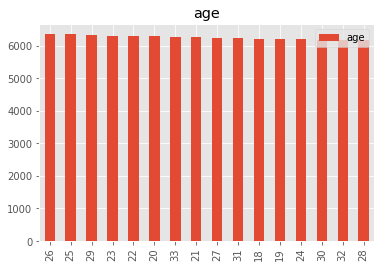

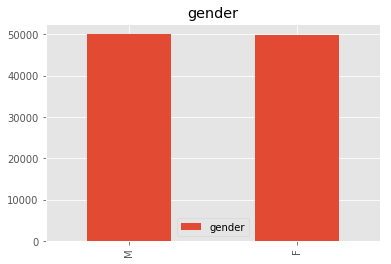

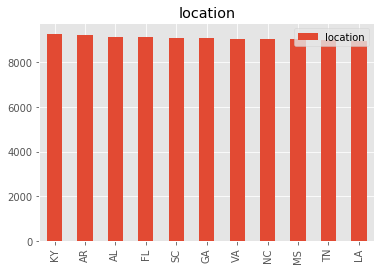

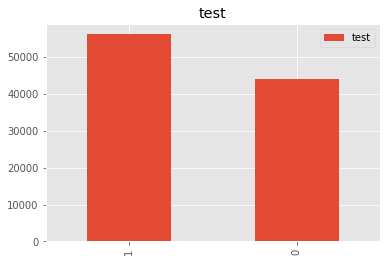

In [21]:
df_user_attributes[['age']].apply(pd.value_counts).plot(kind='bar', subplots=True)
df_user_attributes[['gender']].apply(pd.value_counts).plot(kind='bar', subplots=True)
df_user_attributes[['location']].apply(pd.value_counts).plot(kind='bar', subplots=True)
df_user_attributes[['test']].apply(pd.value_counts).plot(kind='bar', subplots=True)

- the distributions of age, gender, and location are flat/ balanced (equal across their subclasses) 
- test has more samples in the control group as opposed to the test group

In [22]:
###################################################################################################################### 
######################################################################################################################

### merge the two data frames using an inner join on user_id

In [23]:
df_bid_requests_user_attributes_inner = pd.merge(df_user_attributes, df_bid_requests, how='inner', on=['user_id'])
df_bid_requests_user_attributes_outer = pd.merge(df_user_attributes, df_bid_requests, how='outer', on=['user_id'])

### check the merge result

In [24]:
# check the merge result
df_bid_requests_user_attributes_inner[0:5]
print('raw df shapes')
print(df_bid_requests.shape)
print(df_user_attributes.shape)
print('df shape inner join')
print(df_bid_requests_user_attributes_inner.shape)
print('df shape outer join')
print(df_bid_requests_user_attributes_outer.shape)

raw df shapes
(600000, 6)
(100000, 5)
df shape inner join
(600000, 10)
df shape outer join
(636863, 10)


In [25]:
print(df_bid_requests_user_attributes_inner[df_bid_requests_user_attributes_inner["win"].isna()].shape[0])
print(df_bid_requests_user_attributes_outer[df_bid_requests_user_attributes_outer["win"].isna()].shape[0])

0
36863


In [26]:
# look at data frame shape, count NA per column, count and list unique values per column
print(df_shape_nacount_unique_countlist(df_bid_requests_user_attributes_inner))

shape
(600000, 10)

age
Na count
0

gender
Na count
0

location
Na count
0

test
Na count
0

user_id
Na count
0

timestamp
Na count
0

bid
Na count
0

win
Na count
0

conversion
Na count
0

date_time
Na count
0

age
unique count
16
unique list
['33' '26' '29' '31' '20' '23' '30' '18' '28' '24' '32' '22' '27' '21'
 '25' '19']

gender
unique count
2
unique list
['F' 'M']

location
unique count
11
unique list
['FL' 'AL' 'AR' 'SC' 'GA' 'TN' 'LA' 'VA' 'MS' 'NC' 'KY']

test
unique count
2
unique list
['1' '0']

user_id
unique count
63137
unique list
['00003e3b9e5336685200ae85d21b4f5e' '000053b1e684c9e7ea73727b2238ce18'
 '00029153d12ae1c9abe59c17ff2e0895' ... 'fffe56994e6be696722539f962415cd2'
 'ffffda8ada4827900cbf65fd20281080' 'fffffe98d0963d27015c198262d97221']

timestamp
unique count
600000
unique list
['2017-01-01 13:43:34' '2017-01-04 03:59:18' '2017-01-04 17:41:50' ...
 '2017-01-14 17:15:44' '2017-01-19 07:02:42' '2017-01-19 20:09:59']

bid
unique count
2
unique list
[1 0]

win
unique 

In [27]:
# look at data frame shape, count NA per column, count and list unique values per column
print(df_shape_nacount_unique_countlist(df_bid_requests_user_attributes_outer))
del(df_bid_requests_user_attributes_outer)

shape
(636863, 10)

age
Na count
0

gender
Na count
0

location
Na count
0

test
Na count
0

user_id
Na count
0

timestamp
Na count
36863

bid
Na count
36863

win
Na count
36863

conversion
Na count
36863

date_time
Na count
36863

age
unique count
16
unique list
['33' '26' '29' '27' '31' '18' '19' '20' '23' '30' '28' '22' '24' '32'
 '25' '21']

gender
unique count
2
unique list
['F' 'M']

location
unique count
11
unique list
['FL' 'AL' 'AR' 'SC' 'GA' 'VA' 'TN' 'LA' 'MS' 'KY' 'NC']

test
unique count
2
unique list
['1' '0']

user_id
unique count
100000
unique list
['00003e3b9e5336685200ae85d21b4f5e' '000053b1e684c9e7ea73727b2238ce18'
 '00029153d12ae1c9abe59c17ff2e0895' ... 'fffee5badc626a2ab8086120712e5639'
 'ffffda8ada4827900cbf65fd20281080' 'fffffe98d0963d27015c198262d97221']

timestamp
unique count
600001
unique list
['2017-01-01 13:43:34' '2017-01-04 03:59:18' '2017-01-04 17:41:50' ...
 '2017-01-14 17:15:44' '2017-01-19 07:02:42' '2017-01-19 20:09:59']

bid
unique count
3
unique li

- df_bid_requests_user_attributes_inner has no NA, which is the expected result
- the outer merge showed that 36863 of the df_user_attributes could not be assigned to a timestamp, bid, win, and conversion
- so cannot place these 36863 in the context of time

In [28]:
###################################################################################################################### 
######################################################################################################################

### plot the attribution distribution in the funnel (bid, win, conversation) [and over time]

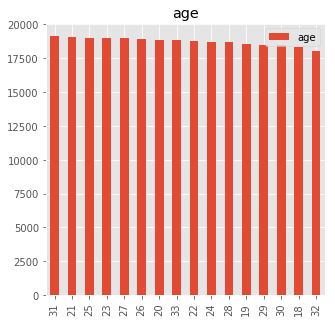

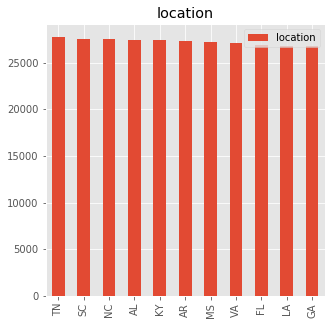

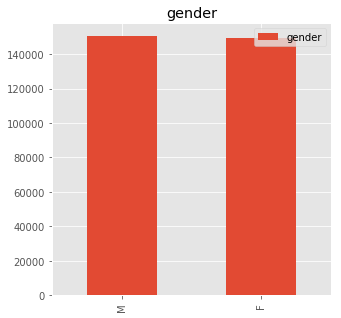

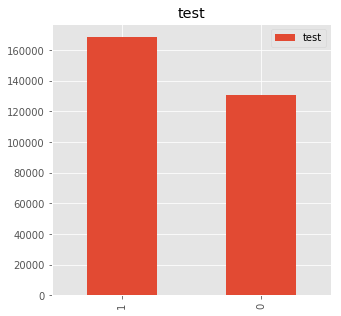

In [29]:
# bids
df_sub = df_bid_requests_user_attributes_inner[df_bid_requests_user_attributes_inner['bid']==1]
# how to use the plot function: plot_attribute_bars(df, test=1, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, test=1, no_time=1)

In [30]:
#plot_attribute_bars(df_sub, day=1)

In [31]:
#plot_attribute_bars(df_sub, hour=1)

 - the bids are balanced (equal bids across the subclasses) with the exception of the test where the test group is larger than the control group

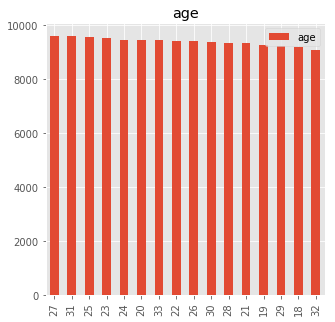

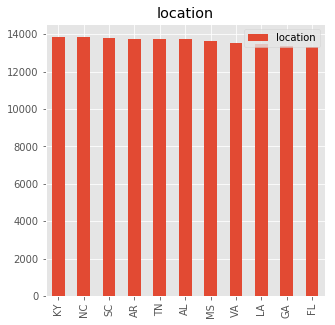

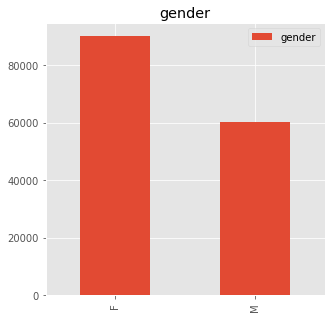

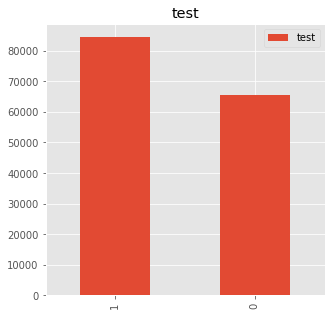

In [32]:
# wins
df_sub = df_bid_requests_user_attributes_inner[df_bid_requests_user_attributes_inner['win']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, test=1, no_time=1)

In [33]:
#plot_attribute_bars(df_sub, day=1)

In [34]:
#plot_attribute_bars(df_sub, hour=1)

- the wins are NOT gender balanced

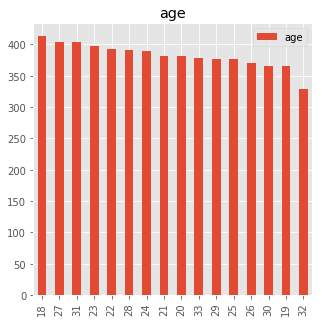

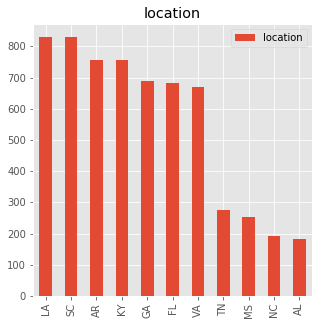

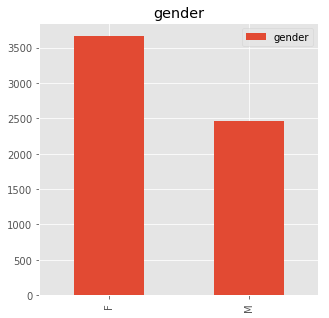

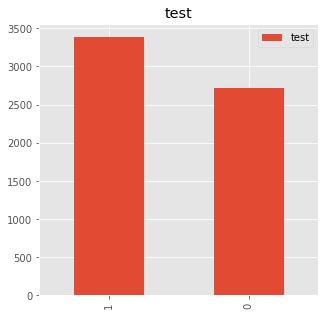

In [35]:
# conversion
df_sub = df_bid_requests_user_attributes_inner[df_bid_requests_user_attributes_inner['conversion']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, test=1, no_time=1)

- the conversions are not balanced w re to gender, and location

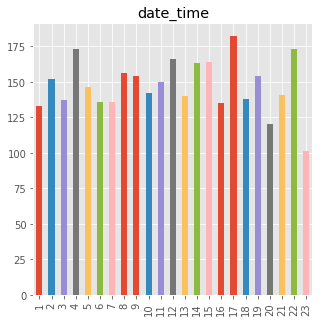

In [114]:
plot_attribute_bars(df_sub, day=1)

In [37]:
#plot_attribute_bars(df_sub, hour=1)

In [38]:
######################################################################################################################
######################################################################################################################

# splitting into control and test group

In [39]:
# test = 0 is the control group while test = 1 is the test group
df_sub_cont = df_bid_requests_user_attributes_inner[df_bid_requests_user_attributes_inner['test']=='0']
df_sub_test = df_bid_requests_user_attributes_inner[df_bid_requests_user_attributes_inner['test']=='1']

 ### sanity checks on fractions of bids, wins and conversions are the same for the control and test group (they should be)

In [40]:
print(df_sub_cont.shape)
print(df_sub_test.shape)

(262107, 10)
(337893, 10)


sample counts differ

In [41]:
# proportion of bids should be the same in both groups
bids_cont=df_sub_cont['bid'].sum()
bids_test=df_sub_test['bid'].sum()
bids_total=bids_cont+bids_test
print ("number of bids in control:", bids_cont)
print ("number of bids in experiment:" ,bids_test)

wins_cont=df_sub_cont['win'].sum()
wins_test=df_sub_test['win'].sum()
wins_total=wins_cont+wins_test
print ("number of wins in control:", wins_cont)
print ("number of wins in experiment:" ,wins_test)

# overall win fraction to estimate expected win fraction
print('wins_total / bids_total')
print(wins_total / bids_total)

print ("number of wins/ bids in control:", wins_cont/bids_cont )
print ("number of wins/ bids in experiment:" , wins_test/bids_test)
print('')

conversion_cont=df_sub_cont['conversion'].sum()
conversion_test=df_sub_test['conversion'].sum()
conversion_total=conversion_cont+conversion_test

print ("number of conversions in control:", conversion_cont)
print ("number of conversions in experiment:" ,conversion_test)
print('')
print('we expect to see differences in the conversions/ wins:')
print ("number of conversions/ wins in control:", conversion_cont/wins_cont )
print ("number of conversions/ wins in experiment:" , conversion_test/wins_test)

number of bids in control: 130995
number of bids in experiment: 168846
number of wins in control: 65564
number of wins in experiment: 84595
wins_total / bids_total
0.5007954215734339
number of wins/ bids in control: 0.5005076529638536
number of wins/ bids in experiment: 0.5010186797436718

number of conversions in control: 2723
number of conversions in experiment: 3392

we expect to see differences in the conversions/ wins:
number of conversions/ wins in control: 0.04153193825880056
number of conversions/ wins in experiment: 0.04009693244281577


- while the counts are different the fractions look similar at first sight at least

In [42]:
######################################################################################################################
######################################################################################################################

#### running a tests modelling the confidence interval for H0 = no significant differences between the control and test group bid success modeled using  a binomial distribution approximated by a normal distribution (when n is large enough)

In [43]:
p=0.5
alpha=0.05
p_hat=round(bids_cont/(bids_total),4)
sd=mt.sqrt(p*(1-p)/(bids_total))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4982 and 0.5018 ; Is 0.4369 inside this range?


- the result confirm that the successful bids are likely not equally distributed between the control and test group (that not 50% of successful bids are in the control group). THIS IS NOT A GREAT START FOR AN A-B TEST

#### running a tests modelling the confidence interval for H0 = no significant differences between the control and test group wins/bids ratio using a pooled standard error

In [44]:
# now testing if the wins as a fraction of bids are equal between the control and test groups
wp_cont=wins_cont/bids_cont
wp_test=wins_test/bids_test
d_hat=round(wp_test-wp_cont,4)
p_pooled=wins_total/bids_total
sd_pooled=mt.sqrt(p_pooled*(1-p_pooled)*(1/bids_cont+1/bids_test))
ME=round(get_z_score(1-(alpha/2))*sd_pooled,4)
print ("The confidence interval is between",0-ME,"and",0+ME,"; Is",d_hat,"within this range?")

The confidence interval is between -0.0036 and 0.0036 ; Is 0.0005 within this range?


- the results do not suggest that we should reject H0 = no significant differences between the control and test group wins/bids ratio. 

Tests from: AB Testing With Python - Walkthrough Udacity's Course Final ProjectBy Tammy Rotem

In [45]:
######################################################################################################################
######################################################################################################################

### compare the control and the test groups' user attribute distributions for bid=1 and win=1

 user attribute distributions should not change as a result of the different creatives as the creative effect should only occur at conversation = 1 but not already at  bid=1 and win=1 

### plotting the df_user_attribute distribution for control and test group (for: bids=1, win=1, conversation=1)

#### control group

##### bid

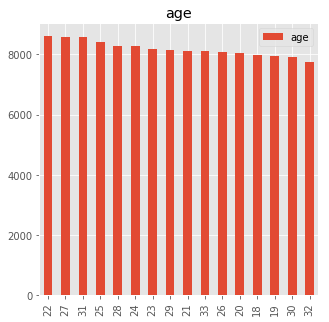

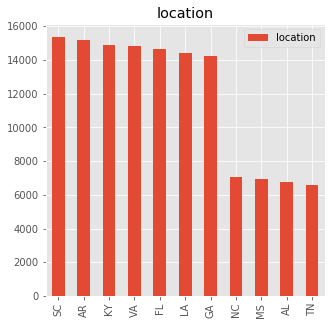

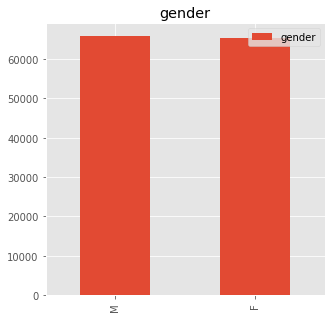

In [46]:
# bids; baseline group (test = 0)
df_sub = df_sub_cont[df_sub_cont['bid']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, no_time=1)

In [47]:
#plot_attribute_bars(df_sub, day=1)

In [48]:
#plot_attribute_bars(df_sub, hour=1)

##### win

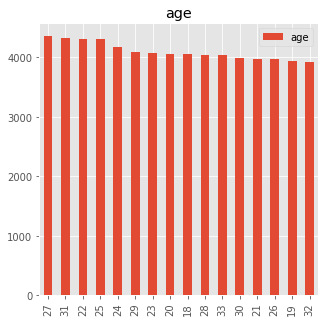

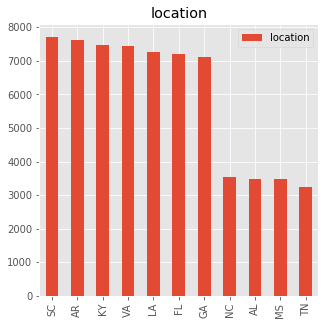

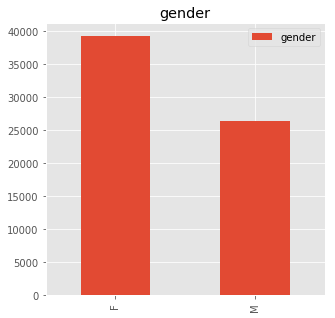

In [49]:
# wins; baseline group (test = 0)
df_sub = df_sub_cont[df_sub_cont['win']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, no_time=1)

In [50]:
#plot_attribute_bars(df_sub, day=1)

In [51]:
#plot_attribute_bars(df_sub, hour=1)

##### conversation

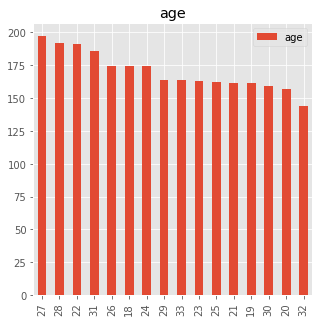

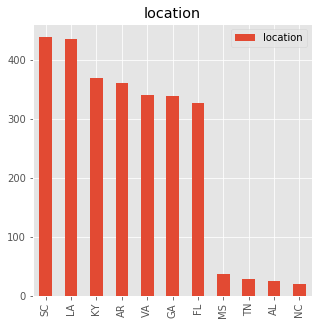

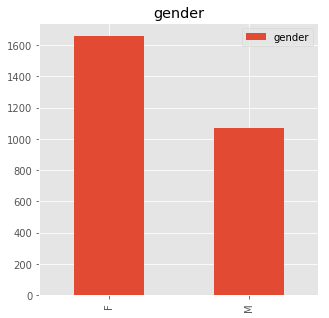

In [52]:
# conversion; baseline group (test = 0)
df_sub = df_sub_cont[df_sub_cont['conversion']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, no_time=1)

In [53]:
#plot_attribute_bars(df_sub, day=1)

In [54]:
#plot_attribute_bars(df_sub, hour=1)

- the control group's bids, wins and conversions are all heterogeneous when it comes to the number of samples per location. wins and conversions also have unequal samples per gender 

#### test group

##### bid

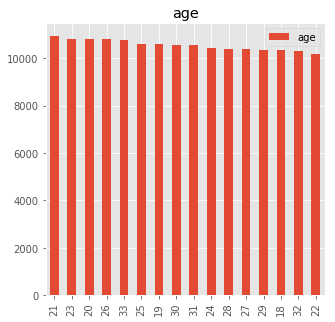

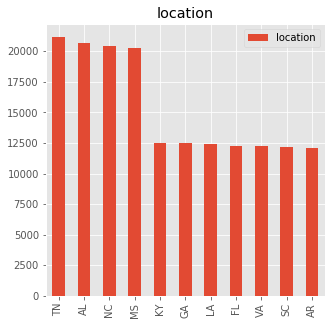

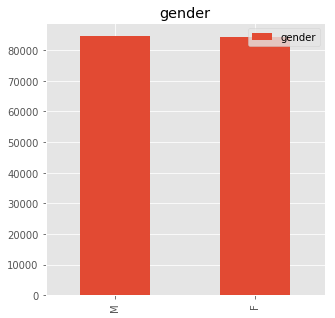

In [55]:
# bids; baseline group (test = 1)
df_sub = df_sub_test[df_sub_test['bid']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, no_time=1)

In [56]:
#plot_attribute_bars(df_sub, day=1)

In [57]:
#plot_attribute_bars(df_sub, hour=1)

##### win

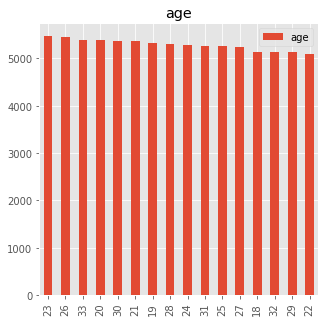

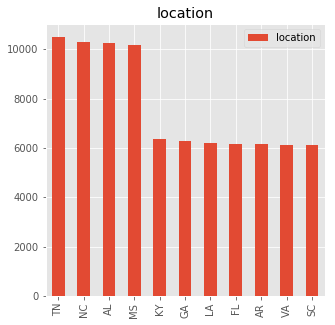

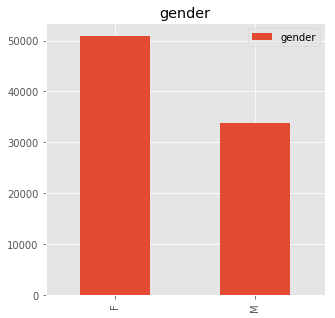

In [58]:
# wins; baseline group (test = 1)
df_sub = df_sub_test[df_sub_test['win']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, no_time=1)

In [59]:
#plot_attribute_bars(df_sub, day=1)

In [60]:
#plot_attribute_bars(df_sub, hour=1)

##### conversation

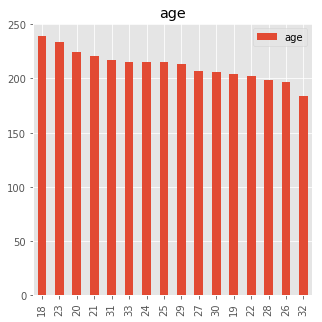

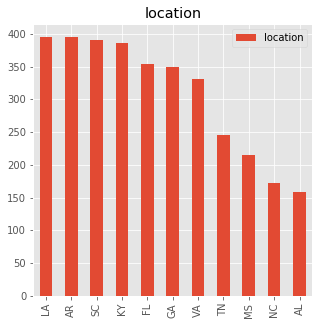

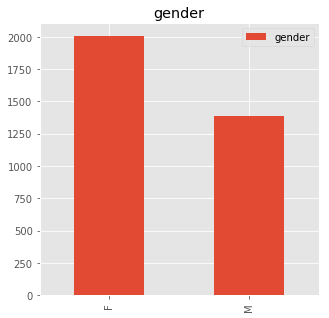

In [61]:
# conversion; baseline group (test = 1)
df_sub = df_sub_test[df_sub_test['conversion']==1]
# how to use the plot function: plot_attribute_bars(df, no_time=0, day=0, hour=0)
plot_attribute_bars(df_sub, no_time=1)

In [62]:
#plot_attribute_bars(df_sub, day=1)

In [63]:
#plot_attribute_bars(df_sub, hour=1)

- the test group's bids, wins and conversions are all heterogeneous when it comes to the number of samples per location. wins and conversions also have unequal samples per gender 

- number of samples per location are also unequal between the control and test group which is an alarm flag!
- having different numbers of samples per state within a group is not an issue as long as the distribution of samples across states is the ~same for the control and test group


#### THE MOST STRIKING SKEW: control vs test group wins: comparing locations

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ff3ec18>],
      dtype=object)

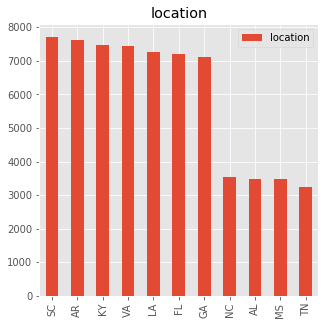

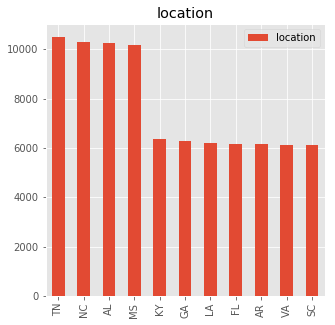

In [64]:
df_sub_cont_win=df_sub_cont[df_sub_cont['win']==1]
df_sub_cont_win[['location']].apply(pd.value_counts).plot(kind='bar', subplots=True)
df_sub_test_win=df_sub_test[df_sub_test['win']==1]
df_sub_test_win[['location']].apply(pd.value_counts).plot(kind='bar', subplots=True)

#### it turns out that e.g. the number of samples for North Carolina are very different between the 
#### control and the test group, so I need to do something about that...

In [65]:
######################################################################################################################
######################################################################################################################

#### I could 'fix' the distribution issue by taking a subsample w inclusion probability equal to the states' population
#### I need equal numbers of bids and wins and user attribute categories in the  control and test groups as the creative should not impact the numbers at the bid and win funnel stage

In [66]:
# I got the population per state from Wikipedia
# State | 2019 Pop. 
Florida_pop = 21646155
Georgia_pop = 10627767
North_Carolina_pop = 10497741
Virginia_pop = 8571946
Tennessee_pop = 6833793
South_Carolina_pop = 5147111
Alabama_pop = 4898246
Louisiana_pop = 4681666
Kentucky_pop = 4484047
Arkansas_pop = 3013825
Mississippi_pop = 2987895

##### I am comparing the ratios of TN population / FL population in a) the control group, b) the test group and c) what they should be like for a random sample over all states where the inclusion probability is a function of the states' population

In [67]:
#print(df_sub_test.shape)
print('ratio of TN / FL occurrences in control group')
print(sum(df_sub_cont['location']=='TN')/sum(df_sub_cont['location']=='FL'))
print('ratio of TN / FL occurrences in test group')
print(sum(df_sub_test['location']=='TN')/sum(df_sub_test['location']=='FL'))

print('ratio of TN / FL population')
print(Tennessee_pop/Florida_pop)

ratio of TN / FL occurrences in control group
0.443163602878483
ratio of TN / FL occurrences in test group
1.7180406699539508
ratio of TN / FL population
0.3157047059858899


##### the fractions do not line up well at all. 

In [68]:
######################################################################################################################
######################################################################################################################

#### going forward I will subsample the existing sample in such a way that I scale the location sample by the population in the states (so as if the sample was drawn at random across the entire area). 
#### I set the sample of NC to 5000 given that NC is one of the large states in term of population that was represented by a relatively small number of samples in the control group (so I down sample to a minority in the sample that should be a majority (so that it can be accommodated) and then scale the n = 5000 of NC by multiplying each state's pop  / NC pop 

#### resulting location distribution is equal between control and test groups and sample size per state is proportional to population size 

In [69]:
NC_sample_n = 5000
FL_sample_n = mt.floor(NC_sample_n * Florida_pop/ North_Carolina_pop)
GA_sample_n = mt.floor(NC_sample_n * Georgia_pop/ North_Carolina_pop)
VA_sample_n = mt.floor(NC_sample_n * Virginia_pop / North_Carolina_pop)
TN_sample_n = mt.floor(NC_sample_n * Tennessee_pop/ North_Carolina_pop)
SC_sample_n = mt.floor(NC_sample_n * South_Carolina_pop / North_Carolina_pop)
AL_sample_n = mt.floor(NC_sample_n * Alabama_pop/ North_Carolina_pop)
KY_sample_n = mt.floor(NC_sample_n * Kentucky_pop/ North_Carolina_pop)
MS_sample_n = mt.floor(NC_sample_n * Mississippi_pop/ North_Carolina_pop)
AR_sample_n = mt.floor(NC_sample_n * Arkansas_pop/ North_Carolina_pop)
LA_sample_n = mt.floor(NC_sample_n * Louisiana_pop/ North_Carolina_pop)

In [70]:
# function call to subsample the states
df_sub_cont_resamp = subsample_state(df_sub_cont)
df_sub_test_resamp = subsample_state(df_sub_test)

#### plot the user attribute distributions of the subsampled data (plot baseline win=1 vs test win=1)

(39712, 10)
(39712, 10)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a26b0ce10>],
      dtype=object)

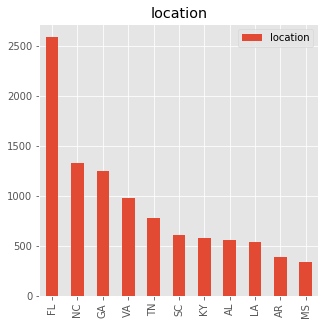

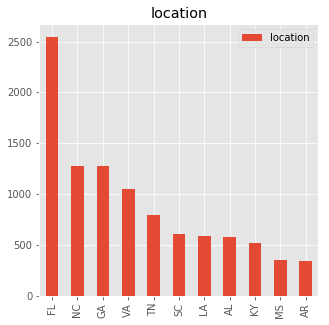

In [71]:
print(df_sub_cont_resamp.shape)
print(df_sub_test_resamp.shape)

# wins; baseline group (test = 0)
df_sub_cont_win=df_sub_test_resamp[df_sub_test_resamp['win']==1]
df_sub_cont_win[['location']].apply(pd.value_counts).plot(kind='bar', subplots=True)

# wins; test group (test = 1)
df_sub_test_win=df_sub_cont_resamp[df_sub_cont_resamp['win']==1]
df_sub_test_win[['location']].apply(pd.value_counts).plot(kind='bar', subplots=True)

Looks great for location (I forced it)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ffca908>],
      dtype=object)

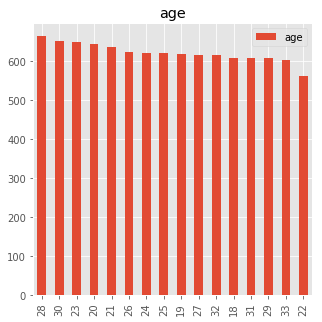

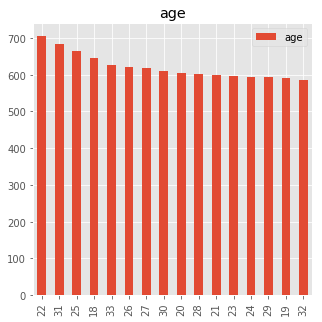

In [72]:
df_sub_cont_win[['age']].apply(pd.value_counts).plot(kind='bar', subplots=True)
df_sub_test_win[['age']].apply(pd.value_counts).plot(kind='bar', subplots=True)

There is still some difference e.g. for age but I am going with it

#### now that the proportions are ~equal between control and experiment, I combine the control and test group data back into a data frame

In [73]:
temp = df_sub_cont_resamp.append(df_sub_test_resamp)
# pick only the cases that were won
df_win = temp[temp['win']==1]
df_win.shape

(19893, 10)

In [74]:
######################################################################################################################
######################################################################################################################

#### Build a summary table containing total control and test (test = 0 and test = 1) as rows and total number of samples, and rate of conversation as columns

In [75]:
ab_summary = df_win.pivot_table(values='conversion', index='test', aggfunc=np.sum)
# additional columns to the pivot table
ab_summary['total'] = df_win.pivot_table(values='conversion', index='test', aggfunc=lambda x: len(x))
ab_summary['rate'] = df_win.pivot_table(values='conversion', index='test')
ab_summary

,conversion,total,rate
test,,,
0,387,9942,0.038926
1,466,9951,0.046829


### read the key results from summary table to use in stats test

In [76]:
A_cr = ab_summary['rate'][0]
B_cr = ab_summary['rate'][1]
A_total = ab_summary['total'][0]
B_total = ab_summary['total'][1]
N_A = A_total
N_B = B_total
A_converted = ab_summary['conversion'][0]
B_converted = ab_summary['conversion'][1]

### pull out the base conversion rate bcr and the difference between the conversion rates d_hat

In [77]:
#Compare the Null Hypothesis vs. the Alternative Hypothesis
# define the parameters for abplot()
# use the actual values from the experiment for base conversion rate (bcr) 
# and difference from base conversion rate (d_hat)
# A_cr is the conversion rate of the control group
# B_cr is the conversion rate of the test group

bcr = A_cr  
d_hat = B_cr - A_cr   
print('N_A: sample size control group')
print(N_A)
print('N_B: sample size test group')
print(N_B)
print('bcr')
print(bcr)
print('d_hat')
print(d_hat)

N_A: sample size control group
9942
N_B: sample size test group
9951
bcr
0.03892576946288473
d_hat
0.007903694912554923


In [78]:
######################################################################################################################
######################################################################################################################

#### Calculate the  sample size for each of the two groups required to detect if the observed change in conversion is significantly different from the detected base rate at 95% level of confidence and with a power of 80% (so we will be 95% certain that we do not make a mistake when rejecting H0 [stating that the conversion rates are not the same; so no false positive]  and so we are 80% sure that we detect a true difference [so no false negative]) 

In [79]:
# min sample size
#min_sample_size(bcr=bcr, mde=0.011, power=0.8, sig_level=0.05)
min_n = min_sample_size(bcr=bcr, mde=d_hat, power=0.8, sig_level=0.05)
print('bcr %')
print(bcr*100)
print('d_hat %')
print(d_hat*100)
print('min_n')
print(min_n)

bcr %
3.892576946288473
d_hat %
0.7903694912554924
min_n
10312.772730962472


In [80]:
#comparing with the samples size I have
print(A_total)
print(B_total)

9942
9951


#### we conclude that our sample is large enough to not make a type 1 (5% chance) or type 2 error (20% chance) hence our chance of a false positive result is 5% and our chance of a false negative result is 20% 

In [81]:
######################################################################################################################
######################################################################################################################

#### run an AB test using the pooled conversion rate and the pool conversion rate standard deviation to marginal error ME around the conversion rate difference GC_diff at 95% confidence
#### H0 = conversion rate did not differ

In [82]:
#Conversion rate = sample size / number of conversations

GC_cont=A_converted/N_A
GC_exp=B_converted/N_B

alpha=0.05
GC={}

GC_pooled=(A_converted+B_converted)/(N_A+N_B) # pooled gross conversion
GC_sd_pooled=mt.sqrt(GC_pooled*(1-GC_pooled)*(1/N_A+1/N_B)) # pooled gross conversion standard deviation
GC_ME=round(get_z_score(1-alpha/2)*GC_sd_pooled,4) #ME is marginal error
GC_diff=round(GC_exp-GC_cont,4) # rounded rate differences


print("The change due to the experiment is",GC_diff*100,"%")
print("Confidence Interval: [",GC_diff-GC_ME,",",GC_diff+GC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. Then we reject H0") 

The change due to the experiment is 0.79 %
Confidence Interval: [ 0.002300000000000001 , 0.013500000000000002 ]
The change is statistically significant if the CI doesn't include 0. Then we reject H0


In [83]:
######################################################################################################################
######################################################################################################################

### plot the AB testing result

#### A metric is statistically significant if the confidence interval does not include 0  (that is, we can be confident there was a change)

#### plot the locations of the two probability distributions (and their means [the conversion rates]) with their 95% confidence intervals and with the test's power. 
#### for the mean test conversion rate's  to be called significantly different it should be outside the control groups confidence interval, its own confidence interval should not cross 0 and the power should be ~80%

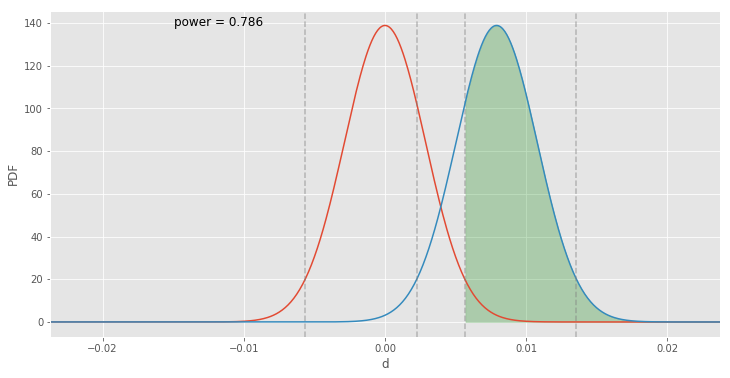

In [84]:
#Statistical Power and Significance Level
abplot(N_A, N_B, bcr, d_hat, show_power=True, show_legend=False) ##show_power=False, show_alpha=False, show_beta=False, show_p_value=False, show_legend=True
## show_power=False, show_alpha=False, show_beta=False, show_p_value=False, show_legend=True

#### all of the above is correct so we have detected a significant difference of d_hat over the bcr base


In [85]:
######################################################################################################################
######################################################################################################################

### RETARGETING

### I  differentiate users a) that had at least one conversation and where show another ad from b) users who had no conversation but were shown multiple ads or users that had a conversation and where not shown another ad

#### I could also go deeper and compare only the a) and b) groups of users who where shown the same number of ads


In [86]:
# select all wins
df_win = df_bid_requests_user_attributes_inner[df_bid_requests_user_attributes_inner['win']==1]

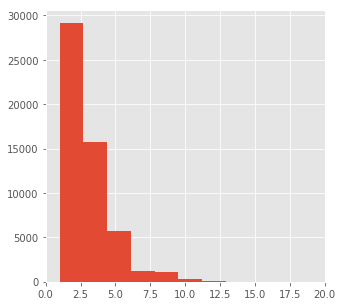

In [87]:
#plot overall reoccurrence of a user name
axes = plt.gca()
axes.set_xlim([0,20])
df_win['user_id'].value_counts().hist()

In [88]:
# loop over and if conversion = 1, then keep the date_time in dict
# for each value if date_time his in dict (had conversion before), add that user_id to a second dict

thisdict1 = {}
thisdict2 = {}
for i in range(0, df_win.shape[0]):
    # get row contents as series using iloc{] and index position of row
    rowSeries = df_win.iloc[i]

    # check if datetime exits in dict
    if(rowSeries['user_id'] in thisdict1):
        thisdict2.update( {rowSeries['user_id'] : ""} )
    elif(rowSeries.conversion == 1):
        # add the datetime to dict
        thisdict1.update( {rowSeries['user_id']: ''} )


print(len(thisdict1))
print(len(thisdict2)) # thisdict2 is the list of users that had at least one conversation and where show another ad

5607
3605


In [89]:
print(df_win.shape)
diff_= df_win[df_win.user_id.isin(thisdict2)] # select users that had at least one conv & where show another ad
print(diff_.shape)
df_win_= df_win[~df_win.user_id.isin(thisdict2)] # select all other no-conv + conv but not shown another ad
print(df_win_.shape)
df_win_ = df_win_.groupby('user_id').filter(lambda x: len(x) > 1) # since the test group consists of users 
# that have seen at least two ads, drop all user_id from the control group that have seen only one ad
print(df_win_.shape)

del(df_win)

df_win_['duplicates'] = 0
diff_['duplicates'] = 1

(150159, 10)
(16928, 10)
(133231, 10)
(117900, 10)


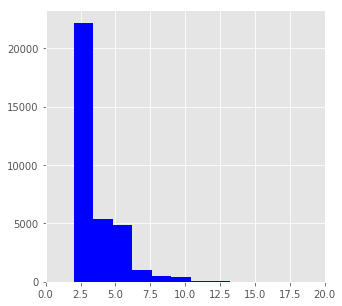

In [90]:
#plot the reoccurrence rate of a user in the two groups
axes = plt.gca()
axes.set_xlim([0,20])
df_win_['user_id'].value_counts().hist(color='blue')

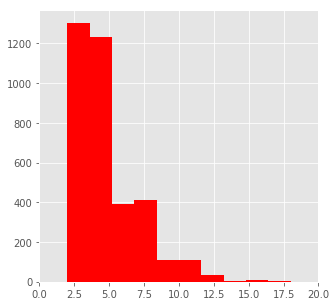

In [91]:
#plot the reoccurrence rate of a user in the two groups
axes = plt.gca()
axes.set_xlim([0,20])
diff_['user_id'].value_counts().hist(color='red')

In [92]:
#combine the control and test group
df_win_ = df_win_.append(diff_)
df_win = df_win_

In [93]:
print(df_win.shape)
ab_summary = df_win.pivot_table(values='conversion', index='duplicates', aggfunc=np.sum)
# additional columns to the pivot table
ab_summary['total'] = df_win.pivot_table(values='conversion', index='duplicates', aggfunc=lambda x: len(x))
ab_summary['rate'] = df_win.pivot_table(values='conversion', index='duplicates')
ab_summary

(134828, 11)


,conversion,total,rate
duplicates,,,
0,1390,117900,0.01179
1,4113,16928,0.24297


##### test if invariant metrices are invariant between test and control group:

In [94]:
### test if invariant metrices are invariant between test and control group:
df_sub_cont = df_win[df_win['duplicates']==0]
df_sub_test = df_win[df_win['duplicates']==1]
print(df_sub_cont.shape)
print(df_sub_test.shape)
#print(df_sub_cont[0:2])
#print('')
#print(df_sub_test[0:2])

(117900, 11)
(16928, 11)


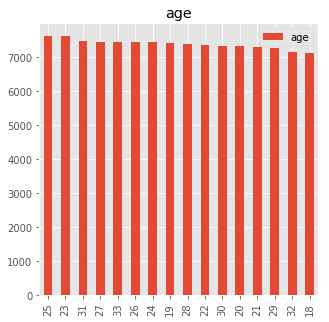

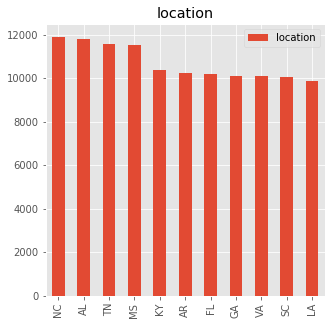

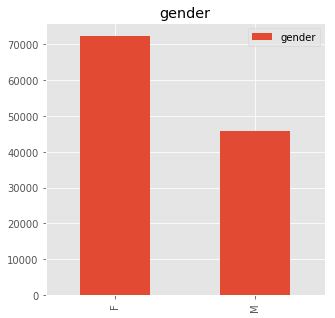

In [95]:
plot_attribute_bars(df_sub_cont, no_time=1)

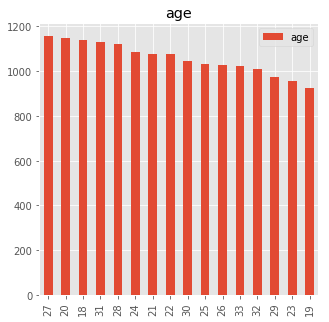

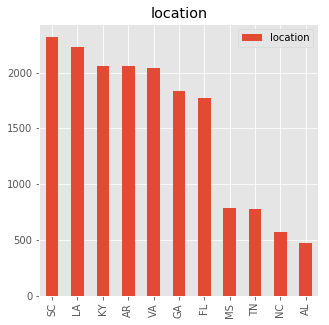

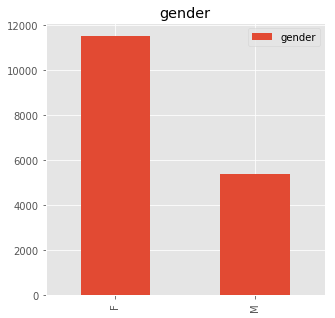

In [96]:
plot_attribute_bars(df_sub_test, no_time=1)

#### again the sample is rather imbalanced. 
#### I shall scale to a random sample of 150 for NC (as one of the smaller groups. 
#### I will also take a sample of 10000 females and 5000 male

In [98]:
male_sample_n = 5000
female_sample_n = 10000

In [99]:
NC_sample_n = 500
FL_sample_n = mt.floor(NC_sample_n * Florida_pop/ North_Carolina_pop)
GA_sample_n = mt.floor(NC_sample_n * Georgia_pop/ North_Carolina_pop)
VA_sample_n = mt.floor(NC_sample_n * Virginia_pop / North_Carolina_pop)
TN_sample_n = mt.floor(NC_sample_n * Tennessee_pop/ North_Carolina_pop)
SC_sample_n = mt.floor(NC_sample_n * South_Carolina_pop / North_Carolina_pop)
AL_sample_n = mt.floor(NC_sample_n * Alabama_pop/ North_Carolina_pop)
KY_sample_n = mt.floor(NC_sample_n * Kentucky_pop/ North_Carolina_pop)
MS_sample_n = mt.floor(NC_sample_n * Mississippi_pop/ North_Carolina_pop)
AR_sample_n = mt.floor(NC_sample_n * Arkansas_pop/ North_Carolina_pop)
LA_sample_n = mt.floor(NC_sample_n * Louisiana_pop/ North_Carolina_pop)

In [100]:
df_sub_in = df_sub_cont
print(df_sub_in.shape)
temp = df_sub_in[df_sub_in['gender']=='M']
temp__=temp.sample(n=male_sample_n, random_state=1)

temp = df_sub_in[df_sub_in['gender']=='F']
temp_=temp.sample(n=female_sample_n, random_state=1)
temp__ = temp__.append(temp_)

df_sub_cont_resamp = temp__
df_sub_cont_resamp.shape

(117900, 11)


(15000, 11)

In [101]:
df_sub_in = df_sub_test
print(df_sub_in.shape)
temp = df_sub_in[df_sub_in['gender']=='M']
temp__=temp.sample(n=male_sample_n, random_state=1)

temp = df_sub_in[df_sub_in['gender']=='F']
temp_=temp.sample(n=female_sample_n, random_state=1)
temp__ = temp__.append(temp_)

df_sub_test_resamp = temp__
df_sub_test_resamp.shape

(16928, 11)


(15000, 11)

In [102]:
print(df_sub_cont_resamp[0:2])
print(df_sub_test_resamp[0:2])

       age gender location test                           user_id  \
528101  19      M       MS    1  e18b1ce90cd151f15a236b6a310cc7f5   
519118  28      M       FL    1  ddc35b596c7252d6f7b91850743fa990   

                  timestamp  bid  win  conversion           date_time  \
528101  2017-01-21 01:09:10    1    1           0 2017-01-21 01:09:10   
519118  2017-01-11 13:47:12    1    1           0 2017-01-11 13:47:12   

        duplicates  
528101           0  
519118           0  
       age gender location test                           user_id  \
485600  23      M       GA    1  cf6c7f1ee880bbf7d446252f8ee27959   
545838  22      M       AL    0  e8de67aac98d923eb372575f30568a89   

                  timestamp  bid  win  conversion           date_time  \
485600  2017-01-20 04:48:59    1    1           0 2017-01-20 04:48:59   
545838  2017-01-03 04:14:52    1    1           0 2017-01-03 04:14:52   

        duplicates  
485600           1  
545838           1  


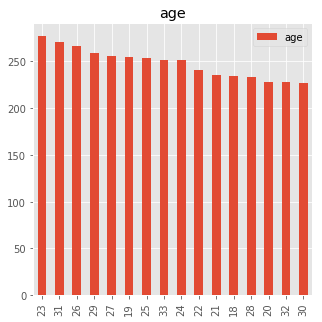

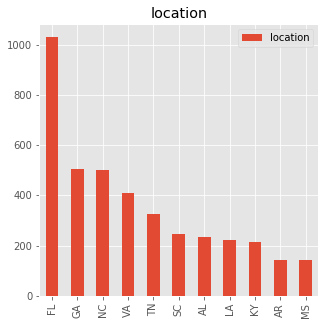

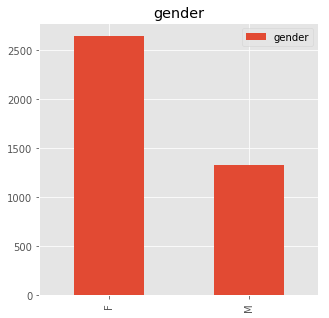

In [103]:
df_sub_cont_resamp_ = subsample_state(df_sub_cont_resamp)
df_sub_cont_resamp_.shape
plot_attribute_bars(df_sub_cont_resamp_, no_time=1)

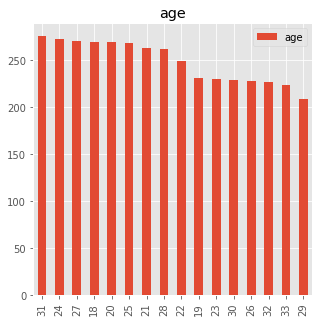

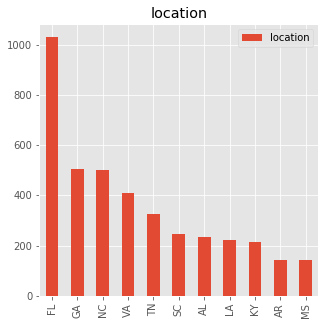

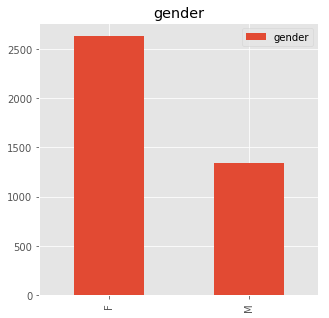

In [104]:
df_sub_test_resamp_ = subsample_state(df_sub_test_resamp)
df_sub_test_resamp_.shape
plot_attribute_bars(df_sub_test_resamp_, no_time=1)

In [105]:
df_win = df_sub_cont_resamp.append(df_sub_test_resamp)
print(df_sub_cont_resamp.shape)
print(df_sub_test_resamp.shape)
print(df_win.shape)

(15000, 11)
(15000, 11)
(30000, 11)


In [106]:
ab_summary = df_win.pivot_table(values='conversion', index='duplicates', aggfunc=np.sum)
# additional columns to the pivot table
ab_summary['total'] = df_win.pivot_table(values='conversion', index='duplicates', aggfunc=lambda x: len(x))
ab_summary['rate'] = df_win.pivot_table(values='conversion', index='duplicates')
ab_summary

,conversion,total,rate
duplicates,,,
0,158,15000,0.010533
1,3673,15000,0.244867


In [107]:
A_cr = ab_summary['rate'][0]
B_cr = ab_summary['rate'][1]
A_total = ab_summary['total'][0]
B_total = ab_summary['total'][1]
N_A = A_total
N_B = B_total
A_converted = ab_summary['conversion'][0]
B_converted = ab_summary['conversion'][1]

In [108]:
#Compare the Null Hypothesis vs. the Alternative Hypothesis
# define the parameters for abplot()
# use the actual values from the experiment for base conversion rate (bcr) 
# and difference from base conversion rate (d_hat)
# A_cr is the conversion rate of the control group
# B_cr is the conversion rate of the test group

bcr = A_cr  
d_hat = B_cr - A_cr   
print('N_A: sample size control group')
print(N_A)
print('N_B: sample size test group')
print(N_B)
print('bcr')
print(bcr)
print('d_hat')
print(d_hat)

N_A: sample size control group
15000
N_B: sample size test group
15000
bcr
0.010533333333333334
d_hat
0.23433333333333334


#### Calculate the  sample size for each of the two groups required to detect if the observed change in conversion is significantly different from the detected base rate at 95% level of confidence and with a power of 80% (so we will be 95% certain that we do not make a mistake when rejecting H0 [stating that the conversion rates are not the same; so no false positive]  and so we are 80% sure that we detect a true difference [so no false negative]) 

In [113]:
# min sample size
min_n =  min_sample_size(bcr=bcr, mde=d_hat, power=0.8, sig_level=0.05)
print('min sample size required per group:')
print(min_n)

min sample size required per group:
31.843903517171988


### We got plenty of samples ...

#### we conclude that our sample is large enough to not make a type 1 (5% chance) or type 2 error (20% chance) hence our chance of a false positive result is 5% and our chance of a false negative result is 20% 

In [110]:
######################################################################################################################
######################################################################################################################

#### run an AB test using the pooled conversion rate and the pool conversion rate standard deviation to marginal error ME around the conversion rate difference GC_diff at 95% confidence

#### H0 = conversion rate did not differ

In [111]:
#####
#Conversion rate = sample size / number of conversations

GC_cont=A_converted/N_A
GC_exp=B_converted/N_B

alpha=0.05
GC={}

GC_pooled=(A_converted+B_converted)/(N_A+N_B) # pooled gross conversion
GC_sd_pooled=mt.sqrt(GC_pooled*(1-GC_pooled)*(1/N_A+1/N_B)) # pooled gross conversion standard deviation
GC_ME=round(get_z_score(1-alpha/2)*GC_sd_pooled,4) #ME is marginal error
GC_diff=round(GC_exp-GC_cont,4) # rounded rate differences


print("The change due to the experiment is",GC_diff*100,"%")
print("Confidence Interval: [",GC_diff-GC_ME,",",GC_diff+GC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. Then we reject H0") 

The change due to the experiment is 23.43 %
Confidence Interval: [ 0.2267 , 0.2419 ]
The change is statistically significant if the CI doesn't include 0. Then we reject H0


### plot the AB testing result

#### A metric is statistically significant if the confidence interval does not include 0  (that is, we can be confident there was a change)

#### plot the locations of the two probability distributions (and their means [the conversion rates]) with their 95% confidence intervals and with the test's power. 
#### for the mean test conversion rate's  to be called significantly different it should be outside the control groups confidence interval, its own confidence interval should not cross 0 and the power should be ~80%

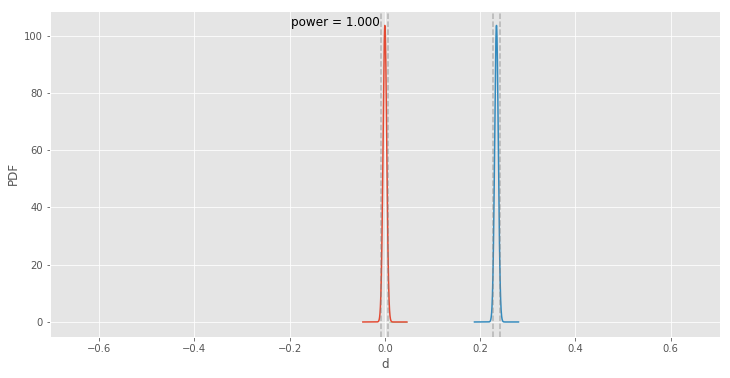

In [112]:
#Statistical Power and Significance Level
abplot(N_A, N_B, bcr, d_hat, show_power=True, show_legend=False) ##show_power=False, show_alpha=False, show_beta=False, show_p_value=False, show_legend=True
## show_power=False, show_alpha=False, show_beta=False, show_p_value=False, show_legend=True
#abplot(N_A, N_B, bcr, d_hat, show_alpha=True) # plot alpha